### Tone frequencies

In [1]:
import pandas as pd
import numpy  as np

**Telephone tone frequencies**

![](tones.png)

**Tone generator**

In [2]:
def tg(num='0',length=1,sr=8000):          # tone generator
    t = np.linspace(1/sr,length,sr*length) #Create the space for the tone, 
                                           #defaults: length = 1 (sec), sr=8000 (sample rate = 8000 samples / sec)
    if num == '*':                         #Change to number index
        num = 10
    elif num == '#':
        num = 11
    else:
        num = int(num)
    
    def w_freq(f):                         #Change degrees to rads
        return 2*np.pi*f
    
    tones = pd.Series([[941,1336],         #Frequencies matrix
                       [697,1209],
                       [697,1336],
                       [697,1477],
                       [770,1209],
                       [770,1336],
                       [770,1477],
                       [852,1209],
                       [852,1336],
                       [852,1477],
                       [941,1209],   
                       [941,1477]])

    return np.sin(w_freq(tones.ix[num][0])*t)+np.sin(w_freq(tones.ix[num][1])*t) #Create number tone by adding the
                                                                                 #2 frequencies

**Tone decoder**

In [3]:
def td(tone,sr=8000): #Tone decoder
    freqs = list(sorted(pd.Series(abs(np.fft.fft(tone)))[:int(sr/2)].sort_values(ascending=False).head(2).index,reverse=True))
                      #Extract tones from signal using fast fourier transform, it will return twice the number
                      #of frequencies we are interested on, so we retrieve only the first half. Sort the values by
                      #magnitude (abs(X+jY)), we are interested only on the 2 top frequencies. This frequencies will be the 
                      #coordinates on the matrix to find the number dialed
    
    lookup = pd.DataFrame([['1','2','3'],
                           ['4','5','6'],
                           ['7','8','9'],
                           ['*','0','#']],
                          columns=[1209,1336,1477],
                          index=[697,770,852,941])
    
    if freqs[1] not in lookup.index or freqs[0] not in lookup.columns: #If either of the frequencies do not correspond
        print('not valid tone')                                        #to a valid frequency, return nan
        return np.nan
    
    return lookup.ix[freqs[1]].ix[freqs[0]] #Return number

Test

In [7]:
for i in range(12):
    print(td(tg(num=str(i))))

0
1
2
3
4
5
6
7
8
9
*
#


---

### Signal generation

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144

**Signal generator**

In [9]:
def s_gen(amp=1.,phase=0.,freq=1,func=np.sin,length=1,sr=44100): #Specify amplitude, phase(º), frequency (Hz), type of 
    t = np.linspace(1/sr,length,sr*length)                       #function, length (sec) and sample rate (Hz)
    return amp*func(2*np.pi*(freq*t+phase/360))                  

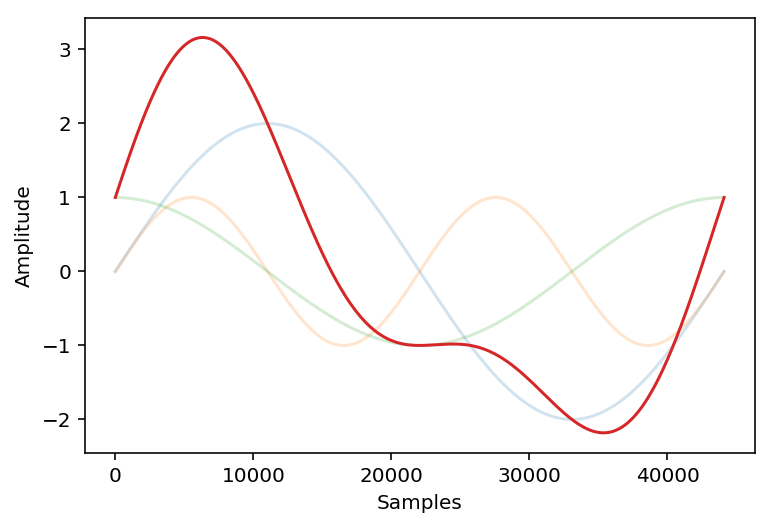

In [15]:
plt.plot(s_gen(amp=2),alpha=0.2)
plt.plot(s_gen(freq=2),alpha=0.2)
plt.plot(s_gen(phase=90),alpha=0.2)
plt.plot(s_gen(amp=2)+s_gen(freq=2)+s_gen(phase=90))
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

**Audio**

In [17]:
import IPython.display

In [19]:
IPython.display.Audio(s_gen(freq=440,length=5),rate=44100) #A4 above middle C used for tunning

**Main frequencies extraction**

In [21]:
def s_fft(x,threshold=0.1,sr=44100):                                          #Signal, minimum threshold of relative
    result = pd.Series(abs(np.fft.fft(x[:sr]))).sort_values(ascending=False)  #magnitude to include, and sampling rate (Hz)
    length = len(result)
    result = result/result.iloc[0]
    result = result.ix[result>=threshold]
    result = result.ix[sorted(result.index)]
    result = result.ix[result.index[:int(len(result.index)/2)]]
    result.index = result.index*(sr/length)
    return result                                               #Outputs all frequencies relative with respect of the
                                                                #frequency with highest magnitud (Ampi/Ampmax) that are
                                                                #over the threshold

**Test**

In [25]:
s_fft(s_gen(freq=440,amp=1)+s_gen(freq=880,amp=0.4)+s_gen(freq=220,amp=2))

220.0    1.0
440.0    0.5
880.0    0.2
dtype: float64

---

### Spectrograms

In [26]:
import librosa

**Record and listen to audio**

In [72]:
test_audio = librosa.load('test2.m4a',sr=44100,mono=True)[0]
IPython.display.Audio(test_audio,rate=44100)

**Audio plot**

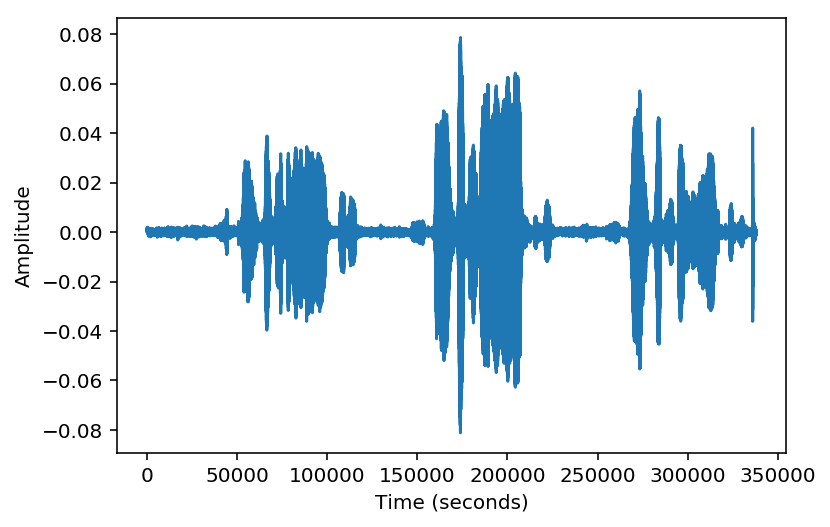

In [73]:
plt.plot(test_audio)
plt.ylabel("Amplitude")
plt.xlabel("Time (seconds)")
plt.show()

**Spectrogram**

Spectrograms are 2D heatmap plots, with the x axis being the time dimension and the y axis being the frequency dimension. 

- **Fs or Sampling frequency:** should be specified and should be the same used to record the the audio.
Human hearing range is from around 30 Hz to 20000 Hz. For cd audio quality a sampling rate of 44100 is used (twice the upper limit of the human range) this is due to Nyquist rate, which says that you should sample at least twice the highest frequency you want to recover (from analog to digital (recording) and digital to analog(playing)). If the sampling rate is inferior to the requested Nyquist frequency, the components that cannot be represented are folded, causing an erroneous spectral representation : this phenomenon is called "aliasing" or spectral folding.

- **NFFT:** Analysis of the signal for the spectrogram is done with a series of (typically overlaping) windows. By specifying the length of the windows we inccur in a tradeoff. A big windows will be able to include more frequencies (particularly lower ones) as it takes a bigger chunk of the signal to analyse (and allows for low frequencies to be included) but that gives us uncertainty on the exact position in time of those frequencies. The window specifies the number of samples to use. The lower the frequency, the larger the window needs to be (1/freq). WS = (Fs/freq)? [1](http://support.ircam.fr/docs/AudioSculpt/3.0/co/Window%20Size.html)

Sample Rate / Window Length = min frequency

- **STFT:** The method to transform a signal from the time domain to the frequency domain for the spectrogram is called the Fourier transform, in this case singe we are interested in the frequency content of a signal along time, chunks of the signal are analysed one by one.  Thus the Short time Fourier transform which is a Fast Fourier Transform for each chunk.

- **FFT:** Fast Fourier Transform is and optimized version of the DFT (Discrete Fourier Transform), whereas the DFT takes O(n^2) time, the FFT takes only O(nlog(n)). There are multiple versions of the FFT.



Knowledge of the type of frequencies expected can help to select those parameters. [2](https://stackoverflow.com/questions/29321696/what-is-a-spectrogram-and-how-do-i-set-its-parameters)

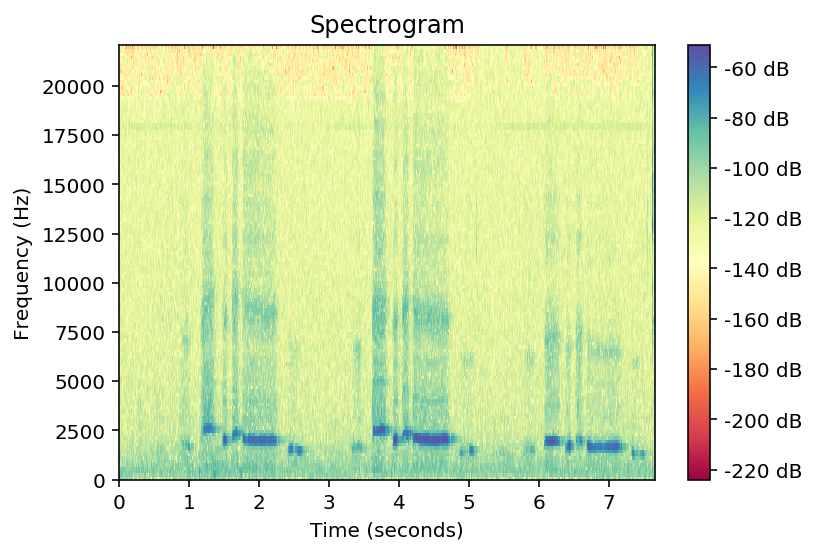

In [82]:
_ = plt.specgram(test_audio,Fs = 44100,NFFT=256,cmap=plt.get_cmap('Spectral'),)
plt.colorbar(format='%+2.0f dB')
plt.ylim(0,22100)
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.show()

In [87]:
s_fft(test_audio[44100:int(1.5*44100)]).sort_values(ascending=False).head(10) #This is analysing the complete signal 

2542.0    1.000000
2562.0    0.996712
2560.0    0.932508
2564.0    0.897025
2540.0    0.886781
2558.0    0.863186
2556.0    0.839087
2566.0    0.833736
2544.0    0.802907
2554.0    0.799924
dtype: float64

**Zero padding**

In [111]:
def padder(x):                                                
    pad   = int(2**np.ceil(np.log2(len(x))))                 #Nearest bigger power of 2
    zeros = pad-len(x)                                       #Zeros needed for such number
    x   = np.pad(x,mode='constant',pad_width=int(zeros/2))  #Pad zeros to the signal
    return x                                                 #Return signal with padded 0's
                                                             #It is done this way because some 

Zero padding increases resolution by interpolation, when bins are not multiples of sampling frequency we *might* miss the exact frequencies

In [112]:
s_fft(padder(test_audio[44100:int(1.5*44100)])).sort_values(ascending=False).head(10) #This is analysing the complete signal 

2542.263794    1.000000
2562.451172    0.998679
2561.105347    0.993244
2540.917969    0.988773
2559.759521    0.930138
2563.796997    0.920459
2558.413696    0.879697
2543.609619    0.868281
2557.067871    0.863056
2565.142822    0.852440
dtype: float64

*There are a few reasons why you might want to zero pad time-domain data. The most common reason is to make a waveform have a power-of-two number of samples. When the time-domain length of a waveform is a power of two, radix-2 FFT algorithms, which are extremely efficient, can be used to speed up processing time. FFT algorithms made for FPGAs also typically only work on lengths of power two.
While it’s often necessary to stick to powers of two in your time-domain waveform length, it’s important to keep in mind how doing that affects the resolution of your frequency-domain output.* [3](http://www.bitweenie.com/listings/fft-zero-padding/)

What waveform frequency resolution do you need?
What FFT resolution do you need?
Does your choice of FFT size allow you to inspect particular frequencies of interest?

- The waveform frequency resolution should be smaller than the minimum spacing between frequencies of interest.
- The FFT resolution should at least support the same resolution as your waveform frequency resolution.    Additionally, some highly-efficient implementations of the FFT require that the number of FFT points be a power of two.
- You should ensure that there are enough points in the FFT, or the FFT has the correct spacing set, so that your frequencies of interest are not split between multiple FFT points.

One final thought on zero padding the FFT:

If you apply a windowing function to your waveform, the windowing function needs to be applied before zero padding the data. This ensures that your real waveform data starts and ends at zero, which is the point of most windowing functions.

---

### Female / Male Voice

In [145]:
voice = pd.read_csv('voicegender.zip')

In [146]:
voice.shape

(3168, 21)

In [147]:
voice.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [148]:
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


- duration: length of signal
- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal
- maxfun: maximum fundamental frequency measured across acoustic signal
- meandom: average of dominant frequency measured across acoustic signal
- mindom: minimum of dominant frequency measured across acoustic signal
- maxdom: maximum of dominant frequency measured across acoustic signal
- dfrange: range of dominant frequency measured across acoustic signal
- modindx: modulation index. Calculated as the accumulated absolute difference between 

In [149]:
voice.ix[voice['label']=='male'].describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,0.170813,0.065110,0.175299,0.115562,0.226346,0.110784,3.295460,48.331698,0.917188,0.471670,0.152022,0.170813,0.115872,0.034175,0.253836,0.728877,0.040307,4.358447,4.318139,0.177430
std,0.026254,0.009455,0.037392,0.031999,0.024050,0.020415,5.135190,163.115940,0.028938,0.150473,0.084024,0.026254,0.017179,0.015749,0.036003,0.445997,0.049199,3.000285,3.000605,0.130132
min,0.039363,0.041747,0.010975,0.000240,0.042946,0.021841,0.326033,2.068455,0.786650,0.080963,0.000000,0.039363,0.055565,0.010953,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.155625,0.058957,0.149952,0.101205,0.211918,0.100960,1.461931,5.003020,0.899557,0.363316,0.098914,0.155625,0.104171,0.017719,0.246154,0.399170,0.007812,1.759766,1.751953,0.099184
50%,0.176343,0.061781,0.180612,0.122315,0.228117,0.109940,1.880420,6.970088,0.917309,0.461636,0.157557,0.176343,0.117254,0.036166,0.271186,0.686687,0.023438,4.457031,4.429688,0.139904
75%,0.190593,0.070915,0.202362,0.136044,0.244819,0.119331,2.645467,12.282596,0.936048,0.576902,0.228117,0.190593,0.128236,0.047572,0.277457,1.032536,0.031250,6.035156,6.000000,0.212205
max,0.225582,0.096030,0.248840,0.226740,0.268924,0.196168,34.537488,1271.353628,0.981997,0.831347,0.280000,0.225582,0.179051,0.121212,0.279070,2.805246,0.458984,21.867188,21.843750,0.932374


In [150]:
voice.ix[voice['label']=='female'].describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,0.191000,0.049142,0.195942,0.165349,0.223184,0.057834,2.984875,24.805224,0.873066,0.344763,0.178541,0.191000,0.169742,0.039429,0.263848,0.929544,0.064987,5.736107,5.671120,0.170073
std,0.029960,0.018380,0.032149,0.049767,0.023121,0.042924,3.091454,97.669114,0.047288,0.179854,0.067175,0.029960,0.018460,0.021845,0.021529,0.576884,0.072739,3.854042,3.856124,0.107639
min,0.078847,0.018363,0.035114,0.000229,0.127637,0.014558,0.141735,2.209673,0.738651,0.036876,0.000000,0.078847,0.091912,0.009775,0.163934,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.177031,0.034977,0.181021,0.157892,0.206280,0.031106,1.962717,6.764500,0.839784,0.208125,0.168883,0.177031,0.157395,0.019116,0.258065,0.450566,0.023438,2.560547,2.435547,0.101201
50%,0.192732,0.041965,0.198226,0.175373,0.223744,0.042689,2.435808,9.607635,0.865861,0.277228,0.193670,0.192732,0.169408,0.047013,0.274286,0.867405,0.023438,6.042969,5.964844,0.138995
75%,0.211981,0.060452,0.216214,0.195243,0.241486,0.061268,3.086396,14.448639,0.908557,0.478122,0.218152,0.211981,0.181832,0.048534,0.277457,1.338521,0.140625,8.607422,8.531250,0.201557
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.978482,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.449219,21.796875,21.773438,0.857764


In [151]:
from sklearn.decomposition import PCA

In [152]:
pca = PCA(n_components=2,whiten=True)

In [153]:
pca.fit(voice.drop('label',axis=1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [154]:
pca2 = pd.DataFrame(pca.transform(voice.drop('label',axis=1)))

In [155]:
pca2.head()

,0,1
0,1.763853,-0.998718
1,4.433292,-0.212414
2,7.325365,0.628608
3,-0.239803,-1.380730
4,-0.239201,0.070536


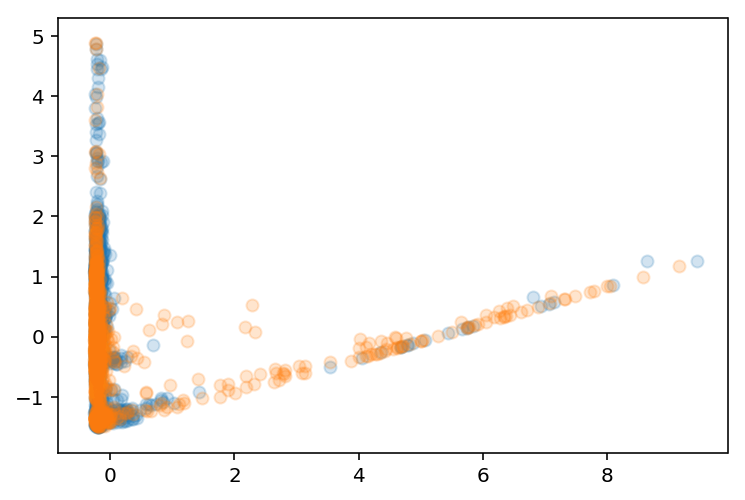

In [162]:
plt.scatter(pca2[0].ix[voice['label']=='female'],pca2[1].ix[voice['label']=='female'],alpha=0.2)
plt.scatter(pca2[0].ix[voice['label']=='male'],pca2[1].ix[voice['label']=='male'],alpha=0.2)
plt.show()

In [358]:
from bokeh.io       import push_notebook, show, output_notebook
from bokeh.layouts  import gridplot, row
from bokeh.palettes import Viridis3, Category10
from bokeh.plotting import figure
from bokeh.models   import HoverTool, BoxSelectTool
from bokeh.charts   import Bar
output_notebook()

Loading BokehJS ...

In [360]:
target = voice['label']
target = target.apply(lambda x: 1 if x == 'male' else 0 )
voice.drop('label',axis=1,inplace=True)

In [364]:
from   sklearn.decomposition import PCA
pca    = PCA(n_components=4,whiten=True)
pca.fit(voice)

domPCA = pd.DataFrame(pca.fit_transform(voice),index=voice.index,columns=['x','y','z','w'])

In [365]:
pca.explained_variance_ratio_

array([  9.98681426e-01,   1.26737277e-03,   4.33224331e-05,
         5.10376822e-06])

In [368]:
p30                  = figure(title = "PCA 1st vs 2nd Dimensions",width=480,height=480)
p30.circle(domPCA['x'].ix[target==0],domPCA['y'].ix[target==0],color=Viridis3[0],fill_alpha=0.2,size=1,legend='Female')
p30.circle(domPCA['x'].ix[target==1],domPCA['y'].ix[target==1],color=Viridis3[1],fill_alpha=0.2,size=1,legend='Male')
p30.xaxis.axis_label = 'Dimension 1'
p30.yaxis.axis_label = 'Dimension 2'
p30.legend.location  = "top_left"

p31                  = figure(title = "PCA 3rd vs 4th Dimensions",width=480,height=480)
p31.circle(domPCA['z'].ix[target==0],domPCA['w'].ix[target==0],color=Viridis3[0],fill_alpha=0.2,size=1,legend='Female')
p31.circle(domPCA['z'].ix[target==1],domPCA['w'].ix[target==1],color=Viridis3[1],fill_alpha=0.2,size=1,legend='Male')
p31.xaxis.axis_label = 'Dimension 3'
p31.yaxis.axis_label = 'Dimension 4'
p31.legend.location  = "top_left"

grid = gridplot([[p30,p31]])
show(grid)

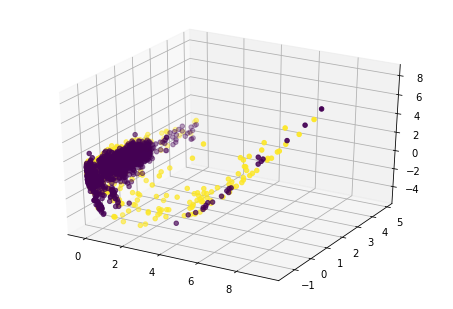

In [367]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig  = plt.figure()
ax   = Axes3D(fig)
surf = ax.scatter(domPCA['x'],domPCA['y'],domPCA['z'],c=target.apply(str))

plt.show()

In [370]:
from sklearn.manifold import TSNE

tsne    = TSNE(n_components=4)

domTSNE = pd.DataFrame(tsne.fit_transform(voice),index=voice.index,columns=['x','y','z','w'])

In [372]:
p30                  = figure(title = "PCA 1st vs 2nd Dimensions",width=480,height=480)
p30.circle(domTSNE['x'].ix[target==0],domTSNE['y'].ix[target==0],color=Viridis3[0],fill_alpha=0.2,size=1,legend='Female')
p30.circle(domTSNE['x'].ix[target==1],domTSNE['y'].ix[target==1],color=Viridis3[1],fill_alpha=0.2,size=1,legend='Male')
p30.xaxis.axis_label = 'Dimension 1'
p30.yaxis.axis_label = 'Dimension 2'
p30.legend.location  = "top_left"

p31                  = figure(title = "PCA 3rd vs 4th Dimensions",width=480,height=480)
p31.circle(domTSNE['z'].ix[target==0],domTSNE['w'].ix[target==0],color=Viridis3[0],fill_alpha=0.2,size=1,legend='Female')
p31.circle(domTSNE['z'].ix[target==1],domTSNE['w'].ix[target==1],color=Viridis3[1],fill_alpha=0.2,size=1,legend='Male')
p31.xaxis.axis_label = 'Dimension 3'
p31.yaxis.axis_label = 'Dimension 4'
p31.legend.location  = "top_left"

grid = gridplot([[p30,p31]])
show(grid)

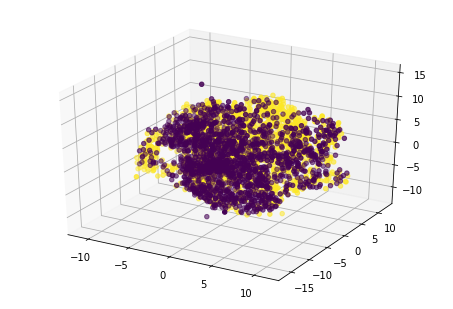

In [373]:
fig  = plt.figure()
ax   = Axes3D(fig)
surf = ax.scatter(domTSNE['x'],domTSNE['y'],domTSNE['z'],c=target.apply(str))

plt.show()

In [126]:
http://www.primaryobjects.com/2016/06/22/identifying-the-gender-of-a-voice-using-machine-learning/
https://www.kaggle.com/primaryobjects/voicegender
https://en.wikipedia.org/wiki/G.711

array([  1.42475857e-04,   2.84951711e-04,   4.27427559e-04, ...,
        -2.84951711e-04,  -1.42475857e-04,  -2.44929360e-16])

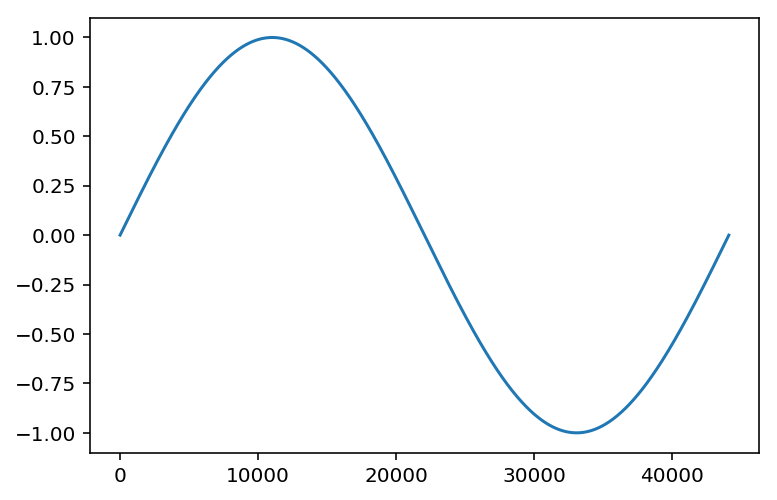

In [166]:
plt.plot(s_gen())
plt.show()

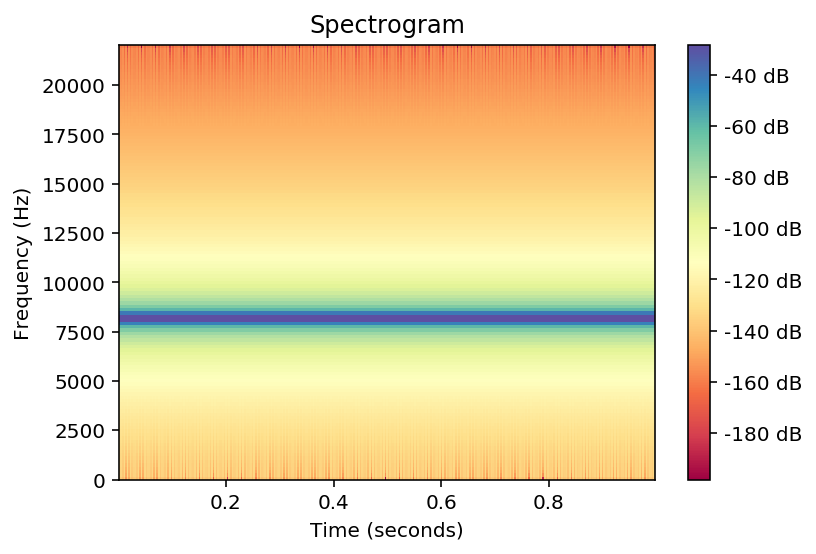

In [191]:
_ = plt.specgram(s_gen(freq=8192),Fs = 44100,NFFT=256,cmap=plt.get_cmap('Spectral'),)
plt.colorbar(format='%+2.0f dB')
plt.ylim(0,22050)
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.show()